In [2]:
from operator import index

import numpy as np
import pandas as pd
from PIL.ImageColor import colormap
from conda.instructions import PRINT
from geopy.distance import distance
from prompt_toolkit.contrib.telnet import TelnetServer
from scipy.spatial.distance import pdist
from setuptools.command.build_ext import if_dl
from win32pdh import counter_status_error
from yt_dlp.extractor.lazy_extractors import PlayPlusTVIE

import SeasonData as sdata

## 3. Nettoyage des données

In [3]:
def additional_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add additional features to the dataframe"""

    # Add shot distance

    # Define the Euclidian distance function
    dist_euclidian = lambda x1, x2: np.round(np.linalg.norm(np.array(x1 - x2)), decimals=1)

    # Add shot distance based on the ice coordinates
    df['shotDistance'] = df.apply(
        lambda x: dist_euclidian(x['iceCoord'], np.array([-89, 0])) if x['iceCoord'][0] <= 0
        else dist_euclidian(x['iceCoord'], np.array([89, 0])), axis=1)
    return df

In [4]:
def minutes_to_seconds(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Convert dataframe column from 'minutes:seconds' to 'seconds' and add the number of period
    """
    # Split columns into 'minutes' and 'seconds' and 'number of period' as integer
    df['minutes'] = df[column].str.split(':').str[0].astype(int)
    df['seconds'] = df[column].str.split(':').str[1].astype(int)
    df['numberPeriod'] = df['currentPeriod'].str.split("/").str[0].astype(int)

    # Total in seconds
    df[column] = df['minutes'] * 60 + df['seconds'] + 20 * 60 * (df['numberPeriod'] - 1)

    #Drop columns
    df.drop(['minutes', 'seconds', 'numberPeriod'], axis=1, inplace=True)

    return df

In [5]:
def extract_players(game_nhl: dict) -> pd.DataFrame:
    """Extract the play-by-play data from the game dictionary"""

    # Extract player data
    df_players = pd.DataFrame(game_nhl['rosterSpots'])[['playerId', 'firstName', 'lastName']]

    # Keep the default name for each player (first and last name)
    df_players['firstName'] = df_players['firstName'].apply(lambda x: x['default'])
    df_players['lastName'] = df_players['lastName'].apply(lambda x: x['default'])
    return df_players

In [6]:
def extract_teams(game_nhl: dict) -> pd.DataFrame:
    """Extract 'home' and 'away' teams"""
    home_team = {'teamId': game_nhl['homeTeam']['id'], 'teamName': game_nhl['homeTeam']['name']['default'],
                 'teamSide': 'home'}
    away_team = {'teamId': game_nhl['awayTeam']['id'], 'teamName': game_nhl['awayTeam']['name']['default'],
                 'teamSide': 'away'}
    return pd.DataFrame([home_team, away_team])

In [7]:
def process_period_data(df: pd.DataFrame) -> pd.DataFrame:
    """Decompose periodDescriptor and return processed dataframe."""
    
    # Split 'periodDescriptor' into 'periodType', 'number', and 'maxRegulationPeriods'
    df_period = pd.DataFrame(df['periodDescriptor'].tolist())

    # Convert 'number' and 'maxRegulationPeriods' columns as strings
    df_period[['number', 'maxRegulationPeriods']] = df_period[['number', 'maxRegulationPeriods']].astype(str)
    return df_period

In [8]:
def process_event_details(df: pd.DataFrame, df_players: pd.DataFrame) -> pd.DataFrame:
    """Process event details and merge with player information."""
    df_details = pd.DataFrame(df['details'].tolist())
    
    # Combine x and y coordinates into a tuple
    df_details['iceCoord'] = df_details[['xCoord', 'yCoord']].apply(tuple, axis=1)

    # Merge 'shooting' and 'scoring' player, to keep only one column
    df_details['shootingPlayerId'] = df_details['shootingPlayerId'].fillna(0) + df_details['scoringPlayerId'].fillna(0)
    
    # Fill missing 'goalieInNetId' values with 0
    df_details['goalieInNetId'] = df_details['goalieInNetId'].fillna(0)
    
    # Convert 'shootingPlayerId' and 'goalieInNetId' as integer
    df_details['shootingPlayerId'] = df_details['shootingPlayerId'].astype(int)
    df_details['goalieInNetId'] = df_details['goalieInNetId'].astype('Int64')  # Int64: handling NaN values

    # Add the shooter names by merging IDs
    df_details = pd.merge(df_players, df_details, left_on='playerId', right_on='shootingPlayerId', how='right').drop(
        columns=['playerId'])

    # Keep only full name
    df_details['shootingPlayer'] = df_details['firstName'] + ' ' + df_details['lastName']
    df_details.drop(['firstName', 'lastName'], axis=1, inplace=True)

    # Add the goalies names by merging IDs 
    df_details = pd.merge(df_players, df_details, left_on='playerId', right_on='goalieInNetId', how='right').drop(
        columns=['playerId'])

    # Keep only full name
    df_details['goaliePlayer'] = df_details['firstName'] + ' ' + df_details['lastName']
    df_details.drop(['firstName', 'lastName'], axis=1, inplace=True)

    return df_details

In [9]:
def calculate_empty_goal_net(df: pd.DataFrame) -> pd.Series:
    """Determine if the goal net is empty"""
    return df.apply(lambda x: x['situationCode'][3] if x['teamSide'] == 'away' else x['situationCode'][0], axis=1).map(
        {'0': True, '1': False})

In [10]:
def determine_goal_advantage(df: pd.DataFrame) -> pd.Series:
    """Determine if the event team is in advantage, disadvantage, or neutral situation"""
    return df.apply(lambda x: "Advantage" if (int(x['situationCode'][1]) > int(x['situationCode'][2]) and x[
        'teamSide'] == 'away') or (int(x['situationCode'][2]) > int(x['situationCode'][1]) and x[
        'teamSide'] == 'home')
    else "Disadvantage" if (int(x['situationCode'][1]) < int(x['situationCode'][2]) and x['teamSide'] == 'away') or
                           (int(x['situationCode'][2]) < int(x['situationCode'][1]) and x['teamSide'] == 'home')
    else 'Neutral', axis=1)

In [11]:
def convert_event_to_dataframe(game_nhl: dict) -> pd.DataFrame:
    """
    Convert NHL game event data into a clean dataframe  
    :param game_nhl: Dictionary containing the data of the NHL game
    :return: A Pandas DataFrame containing filtered data
    """
    # Extract play-by-play data
    df_pbp = pd.DataFrame(game_nhl['plays'])

    # Extract player and team data
    df_players = extract_players(game_nhl)
    df_teams = extract_teams(game_nhl)

    # Create a new dataframe for the event data
    clean_df = pd.DataFrame(df_pbp[['periodDescriptor', 'timeInPeriod', 'situationCode', 'typeDescKey', 'details']])

    # Insert the game ID as the first column
    clean_df.insert(0, 'idGame', game_nhl['id'])

    # Filter to keep only events of type 'shot-on-goal' or 'goal'
    clean_df = clean_df[(clean_df['typeDescKey'] == 'shot-on-goal') | (clean_df['typeDescKey'] == 'goal')].reset_index(
        drop=True)

    # Create a dataframe to decompose the period descriptor fields
    df_period = process_period_data(clean_df)
    clean_df.drop('periodDescriptor', axis=1, inplace=True)

    # Add 'periodType' and 'currentPeriod' columns to the new dataframe
    clean_df.insert(1, 'periodType', df_period['periodType'])
    clean_df.insert(2, 'currentPeriod', df_period['number'] + '/' + df_period['maxRegulationPeriods'])

    # Parse the game's start time to UTC
    start_time = pd.to_datetime(game_nhl['startTimeUTC'])

    # Convert time in the period to seconds and add it to the game start time
    clean_df = minutes_to_seconds(clean_df, 'timeInPeriod')
    clean_df['timeInPeriod'] = start_time + pd.to_timedelta(clean_df['timeInPeriod'], unit='s')

    # Process event details and merge player information
    df_details = process_event_details(clean_df, df_players)
    clean_df.drop('details', axis=1, inplace=True)

    # Add team data by merging IDs
    df_details = pd.merge(df_teams, df_details, left_on='teamId', right_on='eventOwnerTeamId', how='right')

    # Add the extracted data to the new dataframe
    clean_df['iceCoord'] = df_details['iceCoord']
    clean_df['shootingPlayer'] = df_details['shootingPlayer']
    clean_df['goaliePlayer'] = df_details['goaliePlayer']
    clean_df['shotType'] = df_details['shotType']
    clean_df.insert(5, 'eventOwnerTeam', df_details['teamName'])
    clean_df['teamSide'] = df_details['teamSide']

    # Calculate emptyGoalNet and goal advantage
    clean_df['emptyGoalNet'] = calculate_empty_goal_net(clean_df)
    clean_df['isGoalAdvantage'] = determine_goal_advantage(clean_df)

    # Add shot distance
    clean_df = additional_features(clean_df)

    return clean_df

In [12]:
def get_data_from(first_year: int, last_year: int) -> dict:
    
    '''
    Retrieves game data for each season within the specified range of years, processes the events of each game
    (focusing on shots), and organizes the information into a dictionary. The dictionary's keys are the years,
    and the corresponding values are lists of DataFrames, where each DataFrame represents all the shots taken 
    in a particular game during that year.

    Parameters:
    - first (int): The first year (inclusive) from which to retrieve data.
    - last (int): The last year (inclusive) from which to retrieve data.

    Returns:
    - dict: A dictionary where the keys are years, and the values are lists of DataFrames. Each DataFrame corresponds
    to a single game in the specified year and contains information about the shots taken during that game.
    
    '''
    
    all_games_dictionary = {} # Initialize the return dictionary
    data = sdata.NHLData() # Initialize the data object
    
    # Loop over all years
    for year in range(first_year, last_year+1):
        
        # Generate the data from API or local if available
        data.fetch_regular_season(year=year)
        data.fetch_playoffs(year=year)
        yearly_data = data.regular_season[year] + data.playoffs[year] # List with all the games in a year
        
        # Add all the cleaned dataframes (shots per game) for a year to the dictionary
        all_games_dictionary[year] = [convert_event_to_dataframe(game) for game in yearly_data]
    
    return all_games_dictionary

Cette ligne de code est un exemple d'utilisation de la fonction get_data_from()

In [13]:
# This gets all the cleaned data from 2022 to 2023 (inclusive) in a dictionary (key: year)
data_2017_2023 = get_data_from(2022,2023)
data_2017_2023[2022][123].head() # Année 2022, 124eme partie, 5 premières ligne

Data imported: 1312
Data imported: 88
Data imported: 1312
Data imported: 88


,idGame,periodType,currentPeriod,timeInPeriod,situationCode,eventOwnerTeam,typeDescKey,iceCoord,shootingPlayer,goaliePlayer,shotType,teamSide,emptyGoalNet,isGoalAdvantage,shotDistance
0,2022020124,REG,1/3,2022-10-28 23:02:45+00:00,1551,Islanders,shot-on-goal,"(34, 31)",Sebastian Aho,Frederik Andersen,slap,away,False,Neutral,63.1
1,2022020124,REG,1/3,2022-10-28 23:03:42+00:00,1551,Islanders,shot-on-goal,"(78, -16)",Jean-Gabriel Pageau,Frederik Andersen,deflected,away,False,Neutral,19.4
2,2022020124,REG,1/3,2022-10-28 23:04:53+00:00,1551,Hurricanes,shot-on-goal,"(-45, 34)",Brett Pesce,Ilya Sorokin,slap,home,False,Neutral,55.6
3,2022020124,REG,1/3,2022-10-28 23:04:57+00:00,1551,Hurricanes,shot-on-goal,"(-74, 7)",Jesper Fast,Ilya Sorokin,wrist,home,False,Neutral,16.6
4,2022020124,REG,1/3,2022-10-28 23:07:30+00:00,1551,Hurricanes,shot-on-goal,"(-13, -30)",Andrei Svechnikov,Ilya Sorokin,wrist,home,False,Neutral,81.7


## 5. Visualisation avancée

In [ ]:
# Récupérer tous les données de 2022
data_2022 = get_data_from(2022,2022)

Data imported: 1312
Data imported: 88


In [14]:
# Récupérer le nom de chaque équipe de l'année 2022
teams = pd.concat([df['eventOwnerTeam'] for df in data_2022[2022]])
unique_teams = teams.unique()
print(unique_teams)

['Sharks' 'Predators' 'Lightning' 'Rangers' 'Golden Knights' 'Kings'
 'Capitals' 'Bruins' 'Hurricanes' 'Blue Jackets' 'Maple Leafs' 'Canadiens'
 'Avalanche' 'Blackhawks' 'Ducks' 'Kraken' 'Canucks' 'Oilers' 'Penguins'
 'Coyotes' 'Flyers' 'Devils' 'Senators' 'Sabres' 'Panthers' 'Islanders'
 'Stars' 'Wild' 'Flames' 'Red Wings' 'Jets' 'Blues']


#### Here I need to create a dictionary with a DataFrame for each team. Those DataFrames will contain all the shots made by each teams for the season 2022, including playoffs.

In [15]:
# Dictionary that will have one DataFrame per team, where the team's name is the key
team_shots_dfs = {}
dfs_list = data_2022[2022] # Simplify

# Loop over each team and filter rows accordingly
for team in unique_teams:
    
    # Creates a DataFrame with only the shots made by a specific team
    team_df = pd.concat([df[df['eventOwnerTeam'] == team] for df in dfs_list])
    
    # Add the new DataFrame to the team_shots_dfs dictionary
    team_shots_dfs[team] = team_df

In [16]:
# Example of teams shots by the San Jose Sharks
team_shots_dfs['Sharks'].head()

,idGame,periodType,currentPeriod,timeInPeriod,situationCode,eventOwnerTeam,typeDescKey,iceCoord,shootingPlayer,goaliePlayer,shotType,teamSide,emptyGoalNet,isGoalAdvantage,shotDistance
0,2022020001,REG,1/3,2022-10-07 18:00:23+00:00,1551,Sharks,shot-on-goal,"(44, 8)",Timo Meier,Juuse Saros,wrist,away,False,Neutral,45.7
4,2022020001,REG,1/3,2022-10-07 18:02:42+00:00,1551,Sharks,shot-on-goal,"(72, 2)",Steven Lorentz,Juuse Saros,tip-in,away,False,Neutral,17.1
6,2022020001,REG,1/3,2022-10-07 18:04:19+00:00,1551,Sharks,shot-on-goal,"(49, 12)",Oskar Lindblom,Juuse Saros,wrist,away,False,Neutral,41.8
7,2022020001,REG,1/3,2022-10-07 18:04:44+00:00,1551,Sharks,shot-on-goal,"(46, 18)",Kevin Labanc,Juuse Saros,slap,away,False,Neutral,46.6
10,2022020001,REG,1/3,2022-10-07 18:08:08+00:00,1541,Sharks,shot-on-goal,"(60, 17)",Kevin Labanc,Juuse Saros,wrist,away,False,Advantage,33.6


## 4. Visualisation simple

In [56]:
data_2022[2022][0].columns#['idGame']

Index(['idGame', 'periodType', 'currentPeriod', 'timeInPeriod',
       'situationCode', 'eventOwnerTeam', 'typeDescKey', 'iceCoord',
       'shootingPlayer', 'goaliePlayer', 'shotType', 'teamSide',
       'emptyGoalNet', 'isGoalAdvantage', 'shotDistance'],
      dtype='object')

# q1  : Relation tirs et buts

In [95]:
data_q1 = pd.concat(data_2022[2022])
q1 = pd.pivot_table(data_q1, values='idGame', index='shotType', columns='typeDescKey', aggfunc='count')
q1['Total'] = q1.sum(axis=1)
q1.loc['Total'] = q1.sum()
q1['% goal'] = round(q1['goal'] / q1['Total'] * 100,2)
q1.sort_values(by='% goal', ascending=False, inplace=True)
q1


typeDescKey,goal,shot-on-goal,Total,% goal
shotType,,,,
cradle,1,1,2,50.00
bat,54,157,211,25.59
deflected,236,1158,1394,16.93
tip-in,908,4818,5726,15.86
poke,65,357,422,15.40
between-legs,8,44,52,15.38
snap,1681,12532,14213,11.83
backhand,785,6229,7014,11.19
Total,9005,79059,88064,10.23


## Plot q1

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns

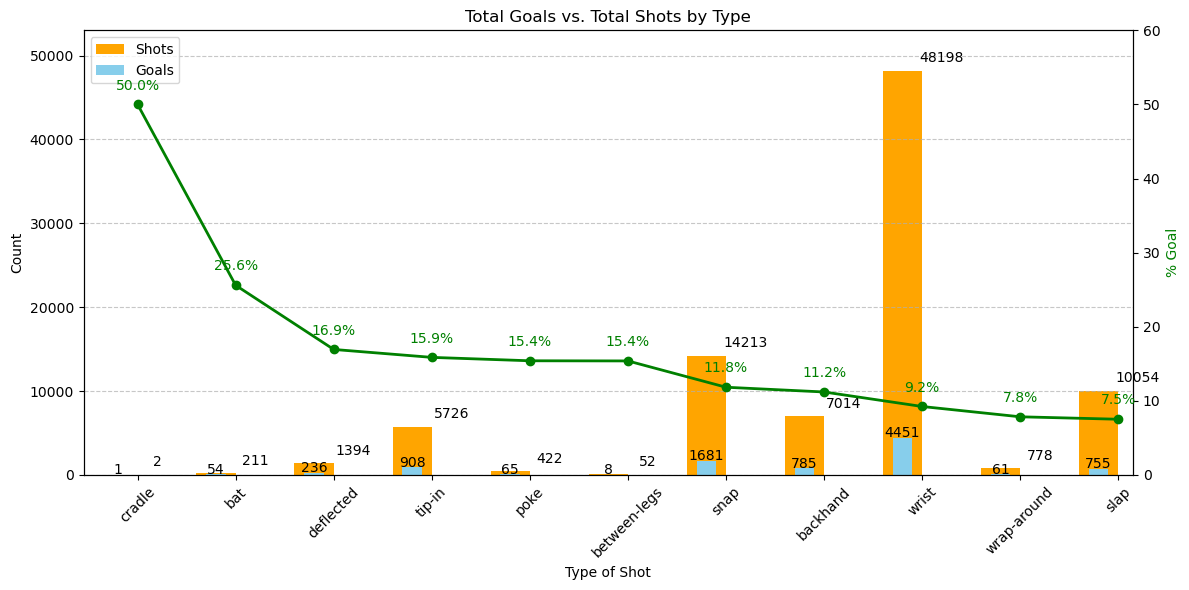

In [140]:
df = pd.DataFrame(q1).drop('Total')

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create bar plots for Total and goals
bars_total = df['Total'].plot(kind='bar', color='orange', position=1, width=0.4, ax=ax1, label='Shots')
bars_goal = df['goal'].plot(kind='bar', color='skyblue', position=1.5, width=0.2, ax=ax1, label='Goals')

# Add titles and labels
ax1.set_title('Total Goals vs. Total Shots by Type')
ax1.set_xlabel('Type of Shot')
ax1.set_ylabel('Count')
ax1.set_xticklabels(df.index, rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')

# Add a second y-axis for % goal
ax2 = ax1.twinx()
ax2.set_ylabel('% Goal', color='green')

# Plot % goal on the secondary y-axis
df['% goal'].plot(kind='line', marker='o', color='green', ax=ax2, label='% Goal', linewidth=2)

# Set y-axis limits for better visibility
ax1.set_ylim(0, df['Total'].max()*1.1)  # Adjust the limit to give space for bars
ax2.set_ylim(0, 60)  # Set limits for % goal

# Annotate values on the bars
for index, value in enumerate(df['Total']):
    ax1.text(index + 0.2, value + 1000, f"{value}", color='black', ha='center')

for index, value in enumerate(df['goal']):
    ax1.text(index - 0.2, value + 50, f"{value}", color='black', ha='center')

# Annotate values on the line
for index, value in enumerate(df['% goal']):
    ax2.text(index, value + 2, f"{round(value,1):.1f}%", color='green', ha='center')
    
# Show the plot
plt.tight_layout()
plt.show()

## Q1.A : Corrélation entre distance de tir, but, et saison

In [167]:
data_2018_2020 = get_data_from(2018,2020)

Data imported: 1271
Data imported: 87
Data imported: 1082
Data imported: 86
Data imported: 868
Data imported: 84


In [230]:
data_2018 = pd.concat(data_2018_2020[2018])
data_2019 = pd.concat(data_2018_2020[2019])
data_2020 = pd.concat(data_2018_2020[2020])
q1a = pd.concat([data_2018, data_2019, data_2020], axis=0)
print(q1a.head())

       idGame periodType currentPeriod              timeInPeriod  \
0  2018020001        REG           1/3 2018-10-03 23:00:29+00:00   
1  2018020001        REG           1/3 2018-10-03 23:00:49+00:00   
2  2018020001        REG           1/3 2018-10-03 23:01:00+00:00   
3  2018020001        REG           1/3 2018-10-03 23:03:54+00:00   
4  2018020001        REG           1/3 2018-10-03 23:04:06+00:00   

  situationCode eventOwnerTeam   typeDescKey    iceCoord     shootingPlayer  \
0          1551      Canadiens  shot-on-goal   (78, -19)   Artturi Lehkonen   
1          1551    Maple Leafs  shot-on-goal  (-37, -10)      Morgan Rielly   
2          1551      Canadiens  shot-on-goal   (47, -23)  Brendan Gallagher   
3          1551      Canadiens  shot-on-goal    (53, 14)  Brendan Gallagher   
4          1551      Canadiens  shot-on-goal    (77, -2)        Mike Reilly   

        goaliePlayer  shotType teamSide  emptyGoalNet isGoalAdvantage  \
0  Frederik Andersen  backhand     away    

In [ ]:
q1a['Year'] = q1a['idGame'].astype(str).str.slice(0,4)
q1a['isGoal'] = q1a['typeDescKey'].apply(lambda x: 1 if x == 'goal' else 0)

In [426]:
q1a['shotDistance'].describe()
q1a['shotDistance_Group'] = q1a['shotDistance'].apply(lambda x: 'a.Under 7 ft.' if x < 7 else ('b.7 - 14.9 ft.' if x < 15 else ('c.15 - 29.9 ft.' if x < 30 else ('d.30 - 44.9 ft.' if x < 45 else 'e.Over 45 ft.'))))
print(q1a['shotDistance_Group'].value_counts())

shotDistance_Group
e.Over 45 ft.      65820
c.15 - 29.9 ft.    52825
d.30 - 44.9 ft.    51976
b.7 - 14.9 ft.     41649
a.Under 7 ft.       5270
Name: count, dtype: int64


In [447]:
q1a_r = pd.pivot_table(q1a, index=['shotDistance_Group'], columns=['Year', 'isGoal'], values='idGame', aggfunc='count')
q1a_r = q1a_r.T.reset_index()
q1a_r['Year_isGoal'] = q1a_r['Year'].astype(str) + '_' + q1a_r['isGoal'].astype(str)
q1a_r = q1a_r.set_index('Year_isGoal')
q1a_r.drop(['Year','isGoal'], axis=1, inplace=True)
q1a_r = q1a_r.T
# q1a_r.index.name = None
q1a_r.columns.name = None
print(q1a_r.index)

Index(['a.Under 7 ft.', 'b.7 - 14.9 ft.', 'c.15 - 29.9 ft.', 'd.30 - 44.9 ft.',
       'e.Over 45 ft.'],
      dtype='object', name='shotDistance_Group')


In [448]:
# q1a_r['shotDistance_Group'] = q1a_r['shotDistance_Group'].astype('category')
q1a_r['2018_Shots'] = q1a_r['2018_0'] + q1a_r['2018_1']
q1a_r['2018_Goals'] = q1a_r['2018_1']
q1a_r['2018_%goals'] = round(q1a_r['2018_Goals'] / q1a_r['2018_Shots'] * 100,2)

q1a_r['2019_Shots'] = q1a_r['2019_0'] + q1a_r['2019_1']
q1a_r['2019_Goals'] = q1a_r['2019_1']
q1a_r['2019_%goals'] = round(q1a_r['2019_Goals'] / q1a_r['2019_Shots'] * 100,2)

q1a_r['2020_Shots'] = q1a_r['2020_0'] + q1a_r['2020_1']
q1a_r['2020_Goals'] = q1a_r['2020_1']
q1a_r['2020_%goals'] = round(q1a_r['2020_Goals'] / q1a_r['2020_Shots'] * 100,2)
# q1a_r.drop(q1a_r['2018'], axis=1, inplace=True)
q1a_net = q1a_r[['2018_Shots', '2018_Goals', '2018_%goals','2019_Shots', '2019_Goals', '2019_%goals', '2020_Shots', '2020_Goals', '2020_%goals']]
print(q1a_net)

                    2018_Shots  2018_Goals  2018_%goals  2019_Shots  \
shotDistance_Group                                                    
a.Under 7 ft.             1746         392        22.45        1960   
b.7 - 14.9 ft.           16873        2913        17.26       13747   
c.15 - 29.9 ft.          20935        2739        13.08       17880   
d.30 - 44.9 ft.          20870        1364         6.54       17474   
e.Over 45 ft.            25515         842         3.30       22806   

                    2019_Goals  2019_%goals  2020_Shots  2020_Goals  \
shotDistance_Group                                                    
a.Under 7 ft.              473        24.13        1564         347   
b.7 - 14.9 ft.            2514        18.29       11029        1977   
c.15 - 29.9 ft.           2331        13.04       14010        1852   
d.30 - 44.9 ft.           1128         6.46       13632         900   
e.Over 45 ft.              676         2.96       17499         560   

    

## Descriptive Table Q1a

In [461]:
q1a_2018 = q1a_net[['2018_Shots', '2018_Goals', '2018_%goals']]
q1a_2019 = q1a_net[['2019_Shots', '2019_Goals', '2019_%goals']]
q1a_2020 = q1a_net[['2020_Shots', '2020_Goals', '2020_%goals']]
# q1a_net
q1a_2018
# q1a_2019
# q1a_2020

,2018_Shots,2018_Goals,2018_%goals,2019_Shots,2019_Goals,2019_%goals,2020_Shots,2020_Goals,2020_%goals
shotDistance_Group,,,,,,,,,
a.Under 7 ft.,1746,392,22.45,1960,473,24.13,1564,347,22.19
b.7 - 14.9 ft.,16873,2913,17.26,13747,2514,18.29,11029,1977,17.93
c.15 - 29.9 ft.,20935,2739,13.08,17880,2331,13.04,14010,1852,13.22
d.30 - 44.9 ft.,20870,1364,6.54,17474,1128,6.46,13632,900,6.60
e.Over 45 ft.,25515,842,3.30,22806,676,2.96,17499,560,3.20


## Plot Q1A

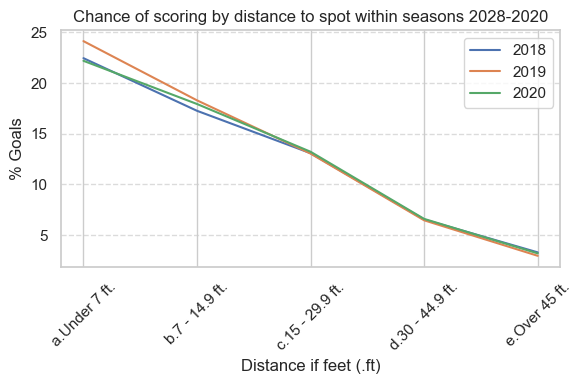

In [460]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=q1a_2018, x='shotDistance_Group', y='2018_%goals', markers=True, dashes=False, label='2018')
sns.lineplot(data=q1a_2019, x='shotDistance_Group', y='2019_%goals', markers=True, dashes=False, label='2019')
sns.lineplot(data=q1a_2020, x='shotDistance_Group', y='2020_%goals', markers=True, dashes=False, label='2020')

plt.title('Chance of scoring by distance of shots within seasons 2028-2020')
plt.xlabel('Distance (.feet)')
plt.ylabel('% Goals')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## Boxplot q1a

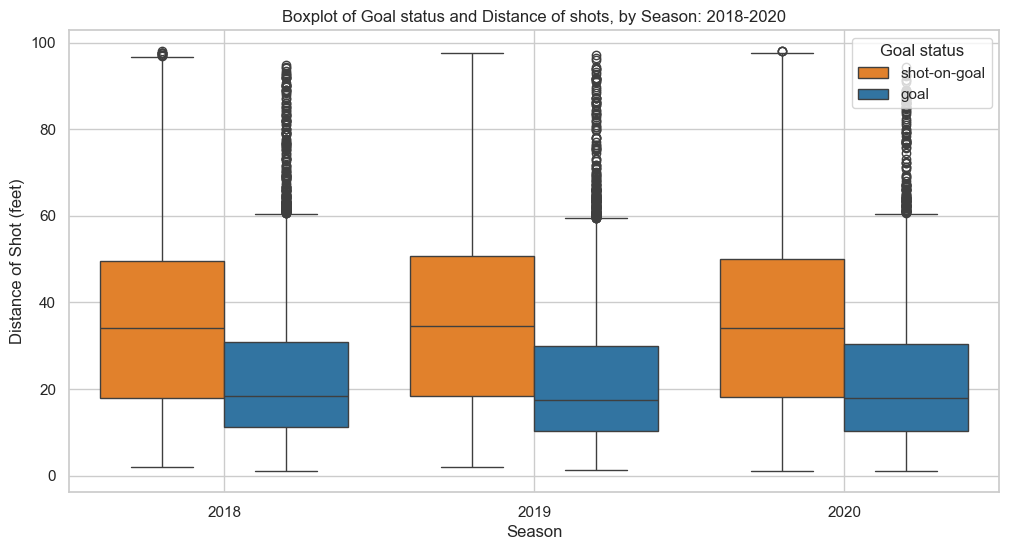

In [477]:
# q1a
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
palette = {'goal': "#1f77b4", 'shot-on-goal': "#ff7f0e"}  # Adjust colors as needed

sns.boxplot(data=q1a, x='Year', y='shotDistance', hue='typeDescKey', palette=palette, dodge=True)
plt.title('Boxplot of Goal status and Distance of shots, by Season: 2018-2020')
plt.xlabel('Season')
plt.ylabel('Distance of Shot (feet)')
plt.legend(title='Goal status', loc='upper right')
plt.grid(True)
plt.show()

## Q2 : Corrélation entre distance de tir, type de tir, et but

In [509]:
q1a['shotType'].unique()

array(['backhand', 'snap', 'wrist', 'wrap-around', 'slap', 'tip-in',
       'deflected', nan], dtype=object)

## Descritive stat

In [508]:
q2_2020 = q1a[q1a['Year']=='2020']
# q2_2020
q2_r = pd.pivot_table(q2_2020, index=['shotDistance_Group'], columns=['shotType', 'isGoal'], values='idGame', aggfunc='count')
# q2_r
q2_r = q2_r.T.reset_index()
q2_r['Type_isGoal'] = q2_r['shotType'] + '_' + q2_r['isGoal'].astype(str)
q2_r = q2_r.set_index('Type_isGoal')
q2_r.drop(['isGoal','shotType'], axis=1, inplace=True)
q2_r = q2_r.T
# q1a_r.index.name = None
q2_r.columns.name = None
print(q2_r.columns)

Index(['backhand_0', 'backhand_1', 'deflected_0', 'deflected_1', 'slap_0',
       'slap_1', 'snap_0', 'snap_1', 'tip-in_0', 'tip-in_1', 'wrap-around_0',
       'wrap-around_1', 'wrist_0', 'wrist_1'],
      dtype='object')


In [527]:
q2_r['backhand_Shots'] = q2_r['backhand_0'] + q2_r['backhand_1']
q2_r['backhand_Goals'] = q2_r['backhand_1']
q2_r['backhand_%goals'] = round(q2_r['backhand_Goals'] / q2_r['backhand_Shots'] * 100,2)

q2_r['deflected_Shots'] = q2_r['deflected_0'] + q2_r['deflected_1']
q2_r['deflected_Goals'] = q2_r['deflected_1']
q2_r['deflected_%goals'] = round(q2_r['deflected_Goals'] / q2_r['deflected_Shots'] * 100,2)

q2_r['slap_Shots'] = q2_r['slap_0'] + q2_r['slap_1']
q2_r['slap_Goals'] = q2_r['slap_1']
q2_r['slap_%goals'] = round(q2_r['slap_Goals'] / q2_r['slap_Shots'] * 100,2)

q2_r['snap_Shots'] = q2_r['snap_0'] + q2_r['snap_1']
q2_r['snap_Goals'] = q2_r['snap_1']
q2_r['snap_%goals'] = round(q2_r['snap_Goals'] / q2_r['snap_Shots'] * 100,2)

q2_r['tip-in_Shots'] = q2_r['tip-in_0'] + q2_r['tip-in_1']
q2_r['tip-in_Goals'] = q2_r['tip-in_1']
q2_r['tip-in_%goals'] = round(q2_r['tip-in_Goals'] / q2_r['tip-in_Shots'] * 100,2)

q2_r['wrap-around_Shots'] = q2_r['wrap-around_0'] + q2_r['wrap-around_1']
q2_r['wrap-around_Goals'] = q2_r['wrap-around_1']
q2_r['wrap-around_%goals'] = round(q2_r['wrap-around_Goals'] / q2_r['wrap-around_Shots'] * 100,2)

q2_r['wrist_Shots'] = q2_r['wrist_0'] + q2_r['wrist_1']
q2_r['wrist_Goals'] = q2_r['wrist_1']
q2_r['wrist_%goals'] = round(q2_r['wrist_Goals'] / q2_r['wrist_Shots'] * 100,2)
# q1a_r.drop(q1a_r['2018'], axis=1, inplace=True)
q2_net = q2_r[['backhand_Shots', 'backhand_Goals', 'backhand_%goals','snap_Shots', 'snap_Goals', 'snap_%goals','slap_Shots', 'slap_Goals', 'slap_%goals','wrist_Shots', 'wrist_Goals', 'wrist_%goals','wrap-around_Shots', 'wrap-around_Goals', 'wrap-around_%goals','tip-in_Shots', 'tip-in_Goals', 'tip-in_%goals','deflected_Shots', 'deflected_Goals', 'deflected_%goals']]
q2_net.fillna(0, inplace=True)
q2_net
# print(q2_net[['wrap-around_Shots', 'wrap-around_Goals', 'wrap-around_%goals']])

C:\Users\maciu\AppData\Local\Temp\ipykernel_9596\2040343271.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q2_net.fillna(0, inplace=True)


,backhand_Shots,backhand_Goals,backhand_%goals,snap_Shots,snap_Goals,snap_%goals,slap_Shots,slap_Goals,slap_%goals,wrist_Shots,...,wrist_%goals,wrap-around_Shots,wrap-around_Goals,wrap-around_%goals,tip-in_Shots,tip-in_Goals,tip-in_%goals,deflected_Shots,deflected_Goals,deflected_%goals
shotDistance_Group,,,,,,,,,,,,,,,,,,,,,
a.Under 7 ft.,279.0,65.0,23.30,61.0,13.0,21.31,18.0,6.0,33.33,715.0,...,25.87,272.0,19.0,6.99,161.0,38.0,23.60,57.0,20.0,35.09
b.7 - 14.9 ft.,2249.0,350.0,15.56,627.0,139.0,22.17,115.0,30.0,26.09,5432.0,...,18.39,270.0,17.0,6.30,1719.0,338.0,19.66,617.0,104.0,16.86
c.15 - 29.9 ft.,1312.0,101.0,7.70,2363.0,408.0,17.27,656.0,121.0,18.45,8664.0,...,12.25,12.0,1.0,8.33,692.0,114.0,16.47,309.0,44.0,14.24
d.30 - 44.9 ft.,333.0,11.0,3.30,2633.0,201.0,7.63,1960.0,199.0,10.15,8603.0,...,5.53,0.0,0.0,0.00,62.0,7.0,11.29,39.0,6.0,15.38
e.Over 45 ft.,280.0,11.0,3.93,2114.0,51.0,2.41,5234.0,205.0,3.92,9557.0,...,2.89,3.0,1.0,33.33,164.0,7.0,4.27,146.0,8.0,5.48


## Descriptive table q2


In [528]:
# 'backhand', 'snap', 'wrist', 'wrap-around', 'slap', 'tip-in', 'deflected'
q2_backhand = q2_net[['backhand_Shots', 'backhand_Goals', 'backhand_%goals']]
q2_snap = q2_net[['snap_Shots', 'snap_Goals', 'snap_%goals']]
q2_wrist = q2_net[['wrist_Shots', 'wrist_Goals', 'wrist_%goals']]
q2_wraparound = q2_net[['wrap-around_Shots', 'wrap-around_Goals', 'wrap-around_%goals']]
q2_slap = q2_net[['slap_Shots', 'slap_Goals', 'slap_%goals']]
q2_tipin = q2_net[['tip-in_Shots', 'tip-in_Goals', 'tip-in_%goals']]
q2_deflected = q2_net[['deflected_Shots', 'deflected_Goals', 'deflected_%goals']]

q2_wraparound

,wrap-around_Shots,wrap-around_Goals,wrap-around_%goals
shotDistance_Group,,,
a.Under 7 ft.,272.0,19.0,6.99
b.7 - 14.9 ft.,270.0,17.0,6.30
c.15 - 29.9 ft.,12.0,1.0,8.33
d.30 - 44.9 ft.,0.0,0.0,0.00
e.Over 45 ft.,3.0,1.0,33.33


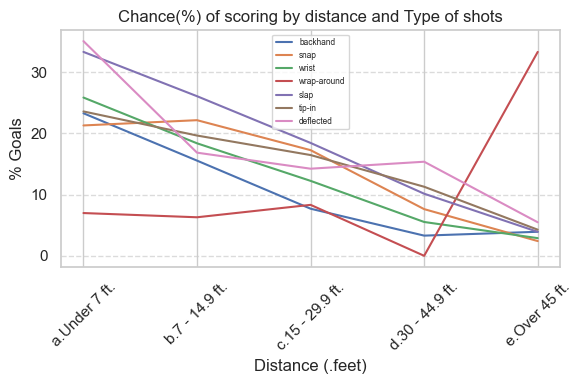

In [535]:
# 'backhand', 'snap', 'wrist', 'wrap-around', 'slap', 'tip-in', 'deflected'
plt.figure(figsize=(6, 4))
sns.lineplot(data=q2_backhand, x='shotDistance_Group', y='backhand_%goals', markers=True, dashes=False, label='backhand')
sns.lineplot(data=q2_snap, x='shotDistance_Group', y='snap_%goals', markers=True, dashes=False, label='snap')
sns.lineplot(data=q2_wrist, x='shotDistance_Group', y='wrist_%goals', markers=True, dashes=False, label='wrist')
sns.lineplot(data=q2_wraparound, x='shotDistance_Group', y='wrap-around_%goals', markers=True, dashes=False, label='wrap-around')
sns.lineplot(data=q2_slap, x='shotDistance_Group', y='slap_%goals', markers=True, dashes=False, label='slap')
sns.lineplot(data=q2_tipin, x='shotDistance_Group', y='tip-in_%goals', markers=True, dashes=False, label='tip-in')
sns.lineplot(data=q2_deflected, x='shotDistance_Group', y='deflected_%goals', markers=True, dashes=False, label='deflected')
plt.title('Chance(%) of scoring by distance and Type of shots')
plt.xlabel('Distance (.feet)')
plt.ylabel('% Goals')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(#title='Type of shot',
           loc='best', prop={'size': 6}, title_fontsize='8')  # Adjust 'size' for labels and 'title_fontsize' for title
plt.tight_layout()
plt.show()

## Boxplot q2

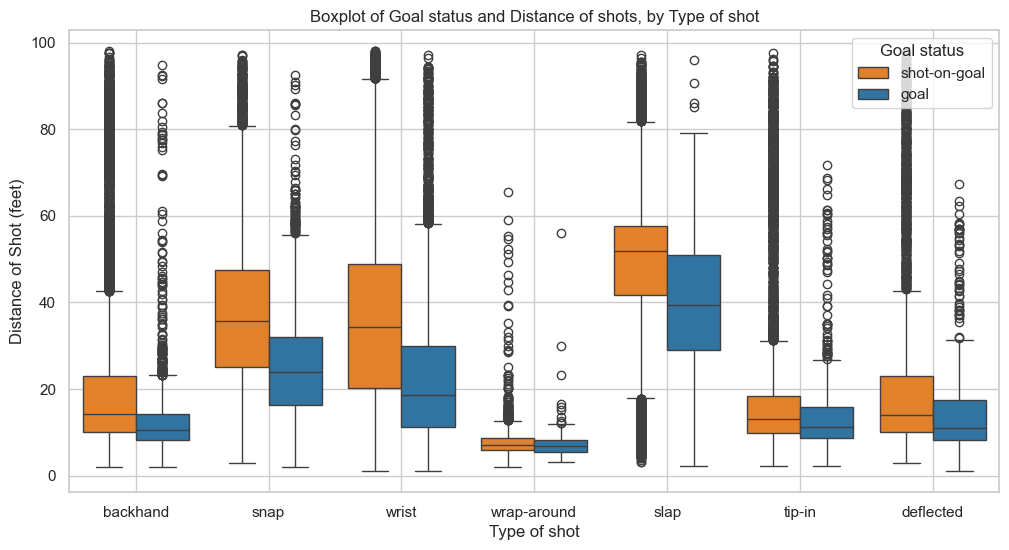

In [537]:
# q1a
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
palette = {'goal': "#1f77b4", 'shot-on-goal': "#ff7f0e"}  # Adjust colors as needed
sns.boxplot(data=q1a, x='shotType', y='shotDistance', hue='typeDescKey', palette=palette, dodge=True)
plt.title('Boxplot of Goal status and Distance of shots, by Type of shot')
plt.xlabel('Type of shot')
plt.ylabel('Distance of Shot (feet)')
plt.legend(title='Goal status', loc='upper right')
plt.grid(True)
plt.show()

### (Youry) 5. Visualisations avancées

In [ ]:
data